In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import gc
import os, random
from collections import Counter
from datetime import datetime

import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from wandb.keras import WandbCallback

import wandb
from wp8.pre_processing.utils import safe_mkdir
from wp8.utils.cnn_rnn_utils import load_and_split
from wp8.utils.dataset import TimeSeriesGenerator as TSG

import matplotlib.pyplot as plt

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)


In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## Options

In [5]:
opt = dotdict(
    {
        "lstm1_units": 128,
        "lstm2_units": 64,
        "dense_units": 32,
        "dropout": 0.4,
        "epochs": 1000,
        "train_actors": [1, 2, 3],
        "val_actors": [4],
        "train_cams": [1, 2, 3,4,5,6,7],
        "val_cams": [1],
        "seq_len": 20,
        "split_ratio": None,
        "drop_offair": True,
        "batch_size": 32,
        "stride": 10,
        "learning_rate": 1e-5,
        "micro_classes": False,
        "oversampler": "random",
        "undersampler": "random",
    }
)


## Load Data

In [6]:
X_train, y_train, X_val, y_val, cams_train, cams_val = load_and_split(
    opt.train_actors, opt.val_actors, opt.train_cams, opt.val_cams, opt.split_ratio, opt.drop_offair, opt.undersample, opt.micro_classes
)
print(f"\nX_train shape: {X_train.shape}, len y_train: {len(y_train)}, X_val shape: {X_val.shape}, len y_val: {len(y_val)}\n")


[STATUS] Load Train Set


  0%|          | 0/44 [00:00<?, ?it/s]

Loading csv datasets:   0%|          | 0/44 [00:00<?, ?it/s]

[STATUS] Load Val Set


  0%|          | 0/6 [00:00<?, ?it/s]

Loading csv datasets:   0%|          | 0/6 [00:00<?, ?it/s]


X_train shape: (346738, 2048), len y_train: 346738, X_val shape: (5624, 2048), len y_val: 5624



## Split in Series

In [7]:
series_gen = TSG(opt)
X_train_series, y_train_series, distrib, classes = series_gen.get_train_series(X_train, y_train, cams_train)
X_val_series, y_val_series = series_gen.get_val_series(X_val, y_val, cams_val)
print(f"\nX_train_series shape: {X_train_series.shape}, len y_train_series: {len(y_train_series)}, X_val_series shape: {X_val_series.shape}, len y_val_series: {len(y_val_series)}\n")

  0%|          | 0/34672 [00:00<?, ?it/s]

Classes mapping:
{'adl': 1, 'falling': 2, 'lying_down': 3}

Class distribution:
Counter({'adl': 24433, 'falling': 6903, 'lying_down': 3336})


  0%|          | 0/561 [00:00<?, ?it/s]


X_train_series shape: (34672, 20, 2048), len y_train_series: 34672, X_val_series shape: (561, 20, 2048), len y_val_series: 561



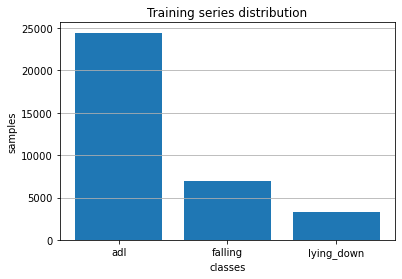

In [8]:
plt.bar(distrib.keys(), distrib.values())
plt.title("Training series distribution")
plt.xlabel("classes")
plt.ylabel("samples")
plt.grid(axis='y')
plt.show()

In [9]:
distrib = Counter(y_train_series).most_common()
print(f"Before resampling - y_train_series shape: {distrib}")

adl_samples, lie_down_samples, fall_samples = distrib[0][1], distrib[1][1], distrib[2][1]

print(f"lie_down_samples: {lie_down_samples}\nadl_samples: {adl_samples}\nfall_samples: {fall_samples}")


Before resampling - y_train_series shape: [(0, 24433), (1, 6903), (2, 3336)]
lie_down_samples: 6903
adl_samples: 24433
fall_samples: 3336


### Resampling


In [10]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
#from imblearn.combine import SMOTETomek

#res_ratio = int(fall_samples*1.5)

#undersampling_strategy = {0: res_ratio, 2: res_ratio, 1: res_ratio}


oversampling_strategy = {0: adl_samples, 1: int(adl_samples * 0.8), 2: int(adl_samples * 0.8)}
undersampling_strategy = "not minority"

#over = RandomOverSampler(random_state=2, sampling_strategy=oversampling_strategy)
under = RandomUnderSampler(random_state=2, sampling_strategy=undersampling_strategy)

#nearmiss = NearMiss(version=3, sampling_strategy=undersampling_strategy)


over = SMOTE(random_state=2, sampling_strategy=oversampling_strategy, n_jobs=-1)

#steps = [("o", over), ("u", under)]
#steps = [("smote", smote), ("u", under)]

steps = [("oversample", over), ("undersample", under)]
pipeline = Pipeline(steps=steps)


In [11]:
print(f"Original X_train_series shape: {X_train_series.shape}")

X_train_series = np.reshape(X_train_series, (-1, opt.seq_len * 2048))
print(f"X_train_series reshaped: {X_train_series.shape}")

X_train_series, y_train_series = pipeline.fit_resample(X_train_series, y_train_series)

X_train_series = np.reshape(X_train_series, (-1, opt.seq_len, 2048))

print(f"After resampling X_train_series shape: {X_train_series.shape}")
print(f"After resampling - y_train_series count: {Counter(y_train_series)}")


Original X_train_series shape: (34672, 20, 2048)
X_train_series reshaped: (34672, 40960)
After resampling X_train_series shape: (58638, 20, 2048)
After resampling - y_train_series count: Counter({0: 19546, 1: 19546, 2: 19546})


In [12]:
# WANDB project initialization
run = wandb.init(
    project="Fall detection CNN + RNN",
    config={
        "model": "LSTM",
        "epochs": opt.epochs,
        "seq_len": opt.seq_len,
        "num_features": 2048,
        "batch_size": opt.batch_size,
        "stride": opt.stride,
        "loss_function": "sparse_categorical_crossentropy",
        "architecture": "LSTM",
        "train_actors": opt.train_actors,
        "val_actors": opt.val_actors,
        "train_cams": opt.train_cams,
        "val_cams": opt.val_cams,
        "micro_classes": opt.classes,
        "dropout": opt.dropout,
        "lstm1_units": opt.lstm1_units,
        "lstm2_units": opt.lstm2_units,
        "dense_units": opt.dense_units,
        "learning_rate": opt.learning_rate,
        "split_ratio": opt.split_ratio,
        "drop_offair": opt.drop_offair,
    },
)

cfg = wandb.config


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andreaapi. Use `wandb login --relogin` to force relogin


## Model

In [13]:
model = Sequential()
model.add(LSTM(units=cfg.lstm1_units, input_shape=(cfg.seq_len, cfg.num_features), return_sequences=True))
model.add(Dropout(cfg.dropout))
model.add(LSTM(units=cfg.lstm2_units, input_shape=(cfg.seq_len, cfg.num_features), return_sequences=False))
model.add(Dropout(cfg.dropout))
model.add(Dense(units=cfg.dense_units, activation="relu"))
model.add(Dropout(cfg.dropout))
model.add(Dense(units=np.unique(y_train_series, axis=0).shape[0], activation="softmax"))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.learning_rate),
    loss=cfg.loss_function,
    metrics=["accuracy", tf.keras.metrics.Recall(class_id=1, name="fall_recall")],
)
model.summary()


2022-06-13 12:32:32.397465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 12:32:32.401891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 12:32:32.402087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 12:32:32.402663: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           1114624   
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 9

## Callbacks

In [14]:
# Callbacks
dir_path = f"model_checkpoints"
safe_mkdir(dir_path)
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")

model_checkpoint = ModelCheckpoint(
    filepath=f"{dir_path}/{cfg.model}_{dt_string}",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    initial_value_threshold=0.8,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="min",
    min_delta=1e-5,
    cooldown=1,
    min_lr=1e-6,
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    verbose=1,
    mode="min",
)

callbacks = [WandbCallback(), model_checkpoint, reduce_lr, early_stop]


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


## Train

In [15]:
# Train Model
history = model.fit(X_train_series, y_train_series, validation_data=(X_val_series, y_val_series), epochs=cfg.epochs, callbacks=callbacks, batch_size=cfg.batch_size)


2022-06-13 12:32:36.888967: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9607249920 exceeds 10% of free system memory.
2022-06-13 12:32:40.431966: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9607249920 exceeds 10% of free system memory.


Epoch 1/1000


2022-06-13 12:32:44.755089: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


  11/1833 [..............................] - ETA: 9s - loss: 1.0992 - accuracy: 0.3324     

2022-06-13 12:32:45.275541: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1831/1833 [============================>.] - ETA: 0s - loss: 0.9931 - accuracy: 0.4810
Epoch 00001: val_loss improved from inf to 1.00016, saving model to model_checkpoints/LSTM_13-06-2022_12:32:33
1833/1833 [==============================] - 12s 6ms/step - loss: 0.9930 - accuracy: 0.4811 - val_loss: 1.0002 - val_accuracy: 0.4759 - _timestamp: 1655116375.0000 - _runtime: 29.0000 - lr: 1.0000e-05
Epoch 2/1000
1828/1833 [============================>.] - ETA: 0s - loss: 0.8234 - accuracy: 0.6069
Epoch 00002: val_loss improved from 1.00016 to 0.86632, saving model to model_checkpoints/LSTM_13-06-2022_12:32:33
1833/1833 [==============================] - 9s 5ms/step - loss: 0.8233 - accuracy: 0.6070 - val_loss: 0.8663 - val_accuracy: 0.6453 - _timestamp: 1655116384.0000 - _runtime: 38.0000 - lr: 1.0000e-05
Epoch 3/1000
1824/1833 [============================>.] - ETA: 0s - loss: 0.7470 - accuracy: 0.6553
Epoch 00003: val_loss improved from 0.86632 to 0.86541, saving model to model_checkpoi

## Evaluate

In [16]:
# Evaluate Model
val_logits = model.predict(X_val_series, batch_size=32, verbose=1)


18/18 [==============================] - 0s 2ms/step


In [17]:
# free up memory
del X_train_series
del X_val_series

gc.collect()


2526

In [18]:
y_pred_val_classes = np.argmax(val_logits, axis=1)

In [19]:
cr = classification_report(y_val_series, y_pred_val_classes, target_names=classes)
print(cr)

              precision    recall  f1-score   support

         adl       0.90      0.87      0.89       367
     falling       0.61      0.30      0.40       136
  lying_down       0.29      0.67      0.40        58

    accuracy                           0.71       561
   macro avg       0.60      0.62      0.56       561
weighted avg       0.76      0.71      0.72       561



In [20]:
# Log metrics to wandb
y_pred_val_classes = np.argmax(val_logits, axis=1).tolist()

cr = classification_report(y_val_series, y_pred_val_classes, target_names=classes, output_dict=True)

wandb.sklearn.plot_roc(y_val_series, val_logits, classes)
wandb.sklearn.plot_class_proportions(y_train_series, y_val_series, classes)
wandb.sklearn.plot_precision_recall(y_val_series, val_logits, classes)
wandb.sklearn.plot_confusion_matrix(y_val_series, y_pred_val_classes, classes)

import pandas as pd
cr = pd.DataFrame(cr)
cr = cr.iloc[:-1, :3].round(2)
cr["metric"] = ["precision", "recall", "f1-score"]

cr_wandb = wandb.Table(dataframe = cr)
wandb.log({"Classification report": cr_wandb})

wandb.join()

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▅▆▅▆▅▆▆▆▆▇▇▇▇██▇▇██████████▇▇▇██▇▇▆▆▆
val_loss,▅▃█▅▄▆▇▆▄▄▅▇▃▃▃▂▆▁▃▃▂▂▂▃▃▄▄▅▄▃▄▄▅▅▅▅▆▇▆▆
accuracy,0.8618
best_epoch,77
best_val_loss,0.80188
epoch,177
loss,0.36204
val_accuracy,0.71479
